In [28]:
import pandas as pd
import numpy as np
import string
import re

from datasets import load_dataset, ClassLabel

from nlp_id.stopword import StopWord
from nlp_id.tokenizer import Tokenizer
from nlp_id.lemmatizer import Lemmatizer

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

Import bahasa baku dan Sarcastic comments

In [29]:
# formal_words_id = load_dataset('theonlydo/indonesia-slang')
# print(formal_words_id['train'])


# # sarcasm_id = load_dataset('w11wo/twitter_indonesia_sarcastic')
# # print(sarcasm_id)

In [30]:
sentimen_telecommunication = load_dataset("dwisaji/indonesia-telecomunication-sentiment-dataset")
sentimen_telecommunication

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2472
    })
})

In [31]:
df_sentimen_telecommunication = sentimen_telecommunication['train'].to_pandas()
df_sentimen_telecommunication.head()

,text,label
0,pastikan internet sobat lancar,0
1,spesial paket on aktif th cuma rb total kuota ...,0
2,oi ngerti bahasa indonesia kan pokoknya sampe ...,2
3,hallo kak kuota &amp,0
4,hai kak alfiyan maaf terkait akses internet la...,0


In [32]:
print(df_sentimen_telecommunication.info())
print('\nMissing Values: \n',df_sentimen_telecommunication.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2472 non-null   object
 1   label   2472 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.8+ KB
None

Missing Values: 
 text     0
label    0
dtype: int64


### convert corpus to lower case

In [33]:
df_sentimen_telecommunication['text'] = df_sentimen_telecommunication['text'].apply(lambda content: " ".join(words.lower() for words in content.split()))
df_sentimen_telecommunication['text']

0                          pastikan internet sobat lancar
1       spesial paket on aktif th cuma rb total kuota ...
2       oi ngerti bahasa indonesia kan pokoknya sampe ...
3                                    hallo kak kuota &amp
4       hai kak alfiyan maaf terkait akses internet la...
                              ...                        
2467      baru tau telkomsel jaringannya cepet kayak gini
2468    hai kak put maaf banget ya terkait sinyal lema...
2469    pagi admin mohon bantuan nomor hp dipakai meng...
2470    halooo mengisi paket data dana terpotong tp ak...
2471    prediksi peandingan bola bayern munchen vs uni...
Name: text, Length: 2472, dtype: object

## Cleaning mark quotion etc.

In [34]:
tokenizer = Tokenizer()
stopword = StopWord()
lemmatizer = Lemmatizer()

In [35]:
import re
import string

def clean_mark(data):
    # Menghapus mention (@username)
    data = re.sub(r'@[A-Za-z0-9]+', '', data)
    
    # Menghapus hashtag (#hashtag)
    data = re.sub(r'#[A-Za-z0-9]+', '', data)
    
    # Menghapus URL
    data = re.sub(r'http\S+', '', data)
    
    # Menghapus angka
    data = re.sub(r'[0-9]+', '', data)

    # Menghapus RT (retweet)
    data = re.sub(r'RT\s+', '', data)
    
    # Menghapus karakter non-huruf dan non-angka
    data = re.sub(r'[^A-Za-z0-9]', ' ', data)

    # Menghapus karakter yang berulang lebih dari dua kali
    data = re.sub(r'(.)\1+', r'\1\1', data)
    
    # Menghapus duplikasi kata berturut-turut
    data = re.sub(r'\b(\w+)( \1\b)+', r'\1', data)
    
    # Menghapus tanda baca berturut-turut
    data = re.sub(r'[\?\.\!]+(?=[\?.\!])', '', data)
    
    # Menghapus tanda baca
    data = data.translate(str.maketrans('', '', string.punctuation))
    
    # Menghapus spasi di awal dan akhir
    data = data.strip()
    
    return data


def remove_emojis(text):
    emoji_pattern = re.compile(
        u'['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbol
        u'\U0001F680-\U0001F6FF'  # transports and map
        u'\U0001F700-\U0001F77F'  # alchemist symbols
        u'\U0001F780-\U0001F7FF'  # geometry symbols
        u'\U0001F800-\U0001F8FF'  # additional symbols
        u'\U0001F900-\U0001F9FF'  # faces, hands, etc.
        u'\U0001FA00-\U0001FA6F'  # additional faces
        u'\U0001FA70-\U0001FAFF'  # additional symbols
        u'\U00002702-\U000027B0'  # hand gestures, symbols
        u'\U000024C2-\U0001F251'  # general emojis
        u'\U0001F004-\U0001F0CF'  # playing card symbols
        u'\U0001F000-\U0001F02F'  # Mahjong
        u'\U0001F1E0-\U0001F1FF'  # Flags
        u'\U0001F200-\U0001F251'  # Enclosed characters
        u']', re.UNICODE)
    
    return re.sub(emoji_pattern, '', text)


In [36]:
df_sentimen_telecommunication['text'] = df_sentimen_telecommunication['text'].apply(clean_mark)
df_sentimen_telecommunication['text'] = df_sentimen_telecommunication['text'].apply(remove_emojis)

df_sentimen_telecommunication

,text,label
0,pastikan internet sobat lancar,0
1,spesial paket on aktif th cuma rb total kuota ...,0
2,oi ngerti bahasa indonesia kan pokoknya sampe ...,2
3,hallo kak kuota amp,0
4,hai kak alfiyan maaf terkait akses internet la...,0
...,...,...
2467,baru tau telkomsel jaringannya cepet kayak gini,0
2468,hai kak put maaf banget ya terkait sinyal lema...,0
2469,pagi admin mohon bantuan nomor hp dipakai meng...,0
2470,haloo mengisi paket data dana terpotong tp akf...,0


### Tokenize text

In [37]:
df_sentimen_telecommunication['text'] = df_sentimen_telecommunication['text'].apply(lambda txt:tokenizer.tokenize(txt))

df_sentimen_telecommunication

,text,label
0,"[pastikan, internet, sobat, lancar]",0
1,"[spesial, paket, on, aktif, th, cuma, rb, tota...",0
2,"[oi, ngerti, bahasa, indonesia, kan, pokok, ny...",2
3,"[hallo, kak, kuota, amp]",0
4,"[hai, kak, alfiyan, maaf, terkait, akses, inte...",0
...,...,...
2467,"[baru, tau, telkomsel, jaringan, nya, cepet, k...",0
2468,"[hai, kak, put, maaf, banget, ya, terkait, sin...",0
2469,"[pagi, admin, mohon, bantuan, nomor, hp, dipak...",0
2470,"[haloo, mengisi, paket, data, dana, terpotong,...",0


### Replace Slang to Formal words

In [38]:
formal_words_id = load_dataset('theonlydo/indonesia-slang')
print(formal_words_id['train'])


Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['slang', 'formal'],
    num_rows: 4412
})


In [39]:
def text_process(txt, slang2formal, stopwords, lemmatize, stemming):
    txt = [slang2formal.get(word.lower(), word) for word in txt]

    txt = [word for word in txt if word.lower() not in stopwords.get_stopword()]

    txt = [lemmatize.lemmatize(word) for word in txt]

    stemmer = stemming.create_stemmer()
    txt = [stemmer.stem(word) for word in txt]


    return " ".join(txt)


slang2formal = dict(zip(formal_words_id['train']['slang'], formal_words_id['train']['formal']))

df_sentimen_telecommunication['text'] = df_sentimen_telecommunication['text'].apply(lambda x: text_process(x, slang2formal, stopword, lemmatizer, StemmerFactory()))

### Remove StopWords

In [40]:
df_sentimen_telecommunication.to_csv('../datasets/cleaned_train_dataset.csv', index=False)

https://www.kaggle.com/code/dewanakretarta/transformer-classification-gojek

https://www.kaggle.com/code/alkidiarete/fastai-gojek-reviews

https://www.kaggle.com/code/rizkia14/analisis-sentimen-unsupervised-lexical#Textblob-Lexicon

https://www.kaggle.com/code/miftahurrizki/eda-topic-modelling-using-pyldavis/notebook

https://www.kaggle.com/code/dewanakretarta/transformer-classification-mobile-legends

<Axes: ylabel='count'>

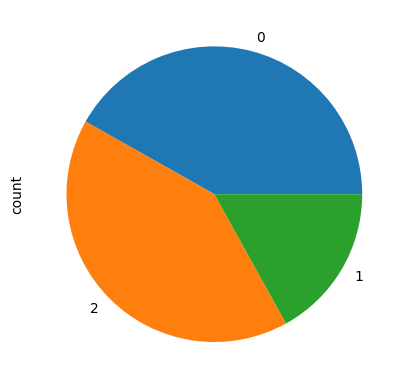

In [44]:
df_train_cleaned = pd.read_csv('../datasets/cleaned_train_dataset.csv')
df_sentimen_telecommunication['label'].value_counts().plot(kind='pie')